# Credit Card Fraud Detection

<!--By JIBIN K-->

Task: 

Build a model to detect fraudulent credit card transactions. Use a dataset containing information about credit card transactions, and experiment with algorithms like Logistic Regression, Decision Trees, or Random Forests to classify transactions as fraudulent or legitimate.

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import joblib

## Load the Dataset

In [2]:
file_path1 = r"D:\CodSoft\CODSOFT\Task 2\fraudTrain.csv"
tr_data = pd.read_csv(file_path1)

## Inspect the train data

In [3]:
print("data shape:", tr_data.shape)
print("---"*30)
print("Dataset variables:", tr_data.columns.to_list())
print("---"*30)
print("Data info: \n"); print(tr_data.info())
print("---"*30)
print("Data description: \n", tr_data.describe(include='all').T)
print("---"*30)
print("Data head:\n", tr_data.head())
print("---"*30)
print("Data tail:\n", tr_data.tail())

data shape: (1296675, 23)
------------------------------------------------------------------------------------------
Dataset variables: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']
------------------------------------------------------------------------------------------
Data info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt             

In [4]:
# Checking for missing values
tr_data.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

- No missing values.

In [5]:
# Checking duplicates
tr_data.duplicated().value_counts()

False    1296675
Name: count, dtype: int64

- No duplicate values.

## Data Cleaning

In [6]:
# Drop unnecessary columns
tr_data.drop([
    'Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street',
    'city', 'state', 'zip', 'dob', 'trans_num', 'unix_time',
    'merch_lat', 'merch_long', 'job', 'merchant'
], axis=1, inplace=True)

# Encode categorical variables
tr_data = pd.get_dummies(tr_data, columns=['category', 'gender'], drop_first=True, dtype=int)
tr_data.head()

,amt,lat,long,city_pop,is_fraud,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,4.97,36.0788,-81.1781,3495,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,107.23,48.8878,-118.2105,149,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,220.11,42.1808,-112.2620,4154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,45.00,46.2306,-112.1138,1939,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,41.96,38.4207,-79.4629,99,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


- Dropped irrelevant columns like transaction time, cardholder details, and merchant info, etc.
- Encoded categorical features (e.g., category, gender) using one-hot encoding.

## Define features and target

In [7]:
X = tr_data.drop('is_fraud', axis=1)
y = tr_data['is_fraud']

## Train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"X train shape: {X_train.shape}\nX test shape: {X_test.shape}\ny tarin shpae: {y_train.shape}\ny test shepe: {y_test.shape}")

X train shape: (1037340, 18)
X test shape: (259335, 18)
y tarin shpae: (1037340,)
y test shepe: (259335,)


## Normalize features

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Evaluation with Stratified K-Fold and SMOTE

In [10]:
# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store metrics
metrics_summary = []

for name, model in models.items():
    print(f"--- {name} ---")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_fold_train, y_fold_train = X_train[train_idx], y_train.iloc[train_idx]
        X_fold_val, y_fold_val = X_train[val_idx], y_train.iloc[val_idx]

        # Apply SMOTE within the fold
        smote = SMOTE(random_state=42)
        X_fold_train_smote, y_fold_train_smote = smote.fit_resample(X_fold_train, y_fold_train)
        
        # Train model
        model.fit(X_fold_train_smote, y_fold_train_smote)
        y_pred = model.predict(X_fold_val)

        accuracy = accuracy_score(y_fold_val, y_pred)
        precision = precision_score(y_fold_val, y_pred)
        recall = recall_score(y_fold_val, y_pred)
        f1 = f1_score(y_fold_val, y_pred)

        metrics_summary.append({
            'Model': name,
            'Fold': fold + 1,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Fold {fold + 1}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("---")

--- Logistic Regression ---
Fold 1:
Accuracy: 0.8736
Precision: 0.0338
Recall: 0.7560
F1 Score: 0.0647
---
Fold 2:
Accuracy: 0.8793
Precision: 0.0357
Recall: 0.7627
F1 Score: 0.0682
---
Fold 3:
Accuracy: 0.8932
Precision: 0.0395
Recall: 0.7485
F1 Score: 0.0751
---
Fold 4:
Accuracy: 0.8847
Precision: 0.0371
Recall: 0.7569
F1 Score: 0.0706
---
Fold 5:
Accuracy: 0.8872
Precision: 0.0369
Recall: 0.7361
F1 Score: 0.0702
---
--- Decision Tree ---
Fold 1:
Accuracy: 0.9939
Precision: 0.4853
Recall: 0.7560
F1 Score: 0.5911
---
Fold 2:
Accuracy: 0.9936
Precision: 0.4666
Recall: 0.7727
F1 Score: 0.5818
---
Fold 3:
Accuracy: 0.9934
Precision: 0.4589
Recall: 0.7677
F1 Score: 0.5745
---
Fold 4:
Accuracy: 0.9939
Precision: 0.4836
Recall: 0.7735
F1 Score: 0.5951
---
Fold 5:
Accuracy: 0.9936
Precision: 0.4672
Recall: 0.7535
F1 Score: 0.5768
---
--- Random Forest ---
Fold 1:
Accuracy: 0.9951
Precision: 0.5551
Recall: 0.7885
F1 Score: 0.6515
---
Fold 2:
Accuracy: 0.9955
Precision: 0.5803
Recall: 0.8060
F

In [11]:
# Convert metrics summary to DataFrame and sort
metrics_df = pd.DataFrame(metrics_summary)
metrics_table = metrics_df.groupby('Model').mean().sort_values(by='F1 Score', ascending=False)
metrics_table.drop(['Fold'], axis=1, inplace=True)
print("\nModel Performance Table:")
print(metrics_table)


Model Performance Table:
                     Accuracy  Precision    Recall  F1 Score
Model                                                       
Random Forest        0.995269   0.564783  0.797502  0.661232
Decision Tree        0.993688   0.472325  0.764696  0.583870
Logistic Regression  0.883592   0.036587  0.752040  0.069769


## Best Model Evaluation

In [12]:
# Select the best model (Random Forest here)
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
y_test_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9970617155416739
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.80      0.66      0.72      1501

    accuracy                           1.00    259335
   macro avg       0.90      0.83      0.86    259335
weighted avg       1.00      1.00      1.00    259335



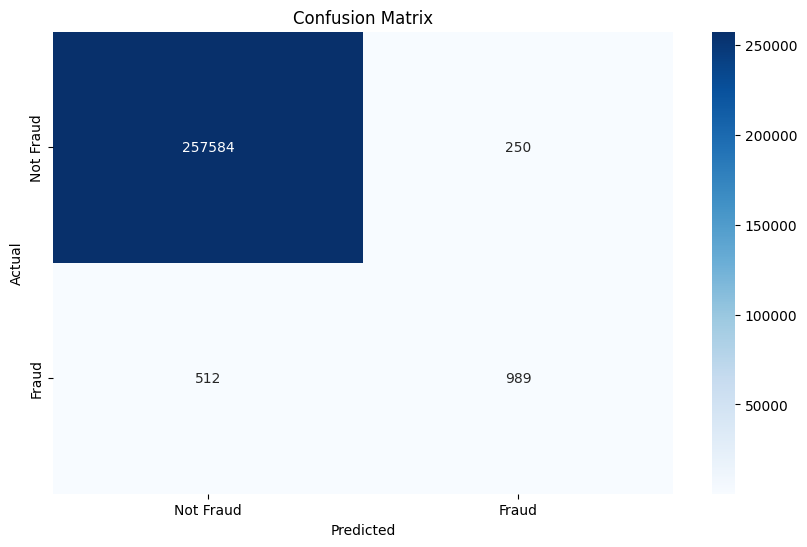

In [14]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Save the model

In [15]:
joblib.dump(best_model, 'fraud_detection_model.pkl')
print("Model saved as 'fraud_detection_model.pkl'")

Model saved as 'fraud_detection_model.pkl'
